In [1]:
import os
import random

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')

In [3]:
import albumentations as A
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

In [6]:
def data_restruct(path):
    # Lista de etiquetas
    labels = os.listdir(path)
    # Cargar las imágenes y las etiquetas
    X, y = [], []
    for i, label in enumerate(labels):
        img_names = os.listdir(os.path.join(path, label))
        for img_name in img_names:
            img_path = os.path.join(path, label, img_name)
            img = cv2.imread(img_path)
            if img.shape[0] != 30 or img.shape[1] != 30:
                print(img_name, label)
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(i) # etiqueta correspondiente a la subcarpeta actual
            
    # Mezclar las listas
    combinadas = list(zip(X, y))
    random.shuffle(combinadas)
    # Desempaquetar las listas mezcladas en dos listas separadas
    X, y = zip(*combinadas)
            
    return np.array(X), np.array(y), labels

In [25]:
train_folder_path = r'C:\Users\migue\OneDrive - Universitat de les Illes Balears\Proyectos\ZAP\FruitFlyNet\scripts\dataset\train'
X_train, y_train, _ = data_restruct(train_folder_path)

test_folder_path = r'C:\Users\migue\OneDrive - Universitat de les Illes Balears\Proyectos\ZAP\FruitFlyNet\scripts\dataset\test'
X_test, y_test, labels = data_restruct(test_folder_path)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(labels)

(88, 30, 30, 3)
(88,)
(118, 30, 30, 3)
(118,)
['black', 'fly', 'frame', 'trap']


In [ ]:
# X_train, X_test = np.split(X, [75])
# y_train, y_test = np.split(y, [75])

# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [10]:
def data_augment(img, transform, n=5, n_fixed = True):
    """
    Función para llevar a cabo aumento de las imágenes.
    Inputs:
        · img (np.array): Imagen a transformar.
        · transform (Albumentations object): Pipeline con las posibles acciones a llevar en la imagen.
        · n (int)
        · n_fixed (bool): Define si n es la cantidad de transformaciones a realizar o la cantidad de veces que se intenta.
    Outputs:
        · - (np.array): Array con las transformaciones realizadas.
    """
    res, counter = [], 0
    while True:
        transf = transform(image=img)['image']
        # Si la transf. resultante es diferente del original
        if not np.array_equal(img, transf) and not np.isin(transf, res).all():
            res.append(transf)
        if (n_fixed == True and len(res) >= n) or (n_fixed == False and counter >= n):
            return np.stack(res, axis=0)
        
        counter += 1

In [11]:
N, N_FIXED = 8, True

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])

Arrays repetidos: []


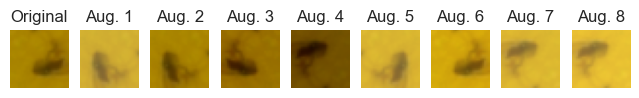

In [15]:
img_index = 3
img, target = X_train[img_index], y_train[img_index]
augmentations = data_augment(img, transform, n=N, n_fixed=N_FIXED)

if augmentations.shape[0] != 0:
    # Comprobar si hay arrays repetidos en la lista
    unique, counts = np.unique(np.array(list(augmentations)), axis=0, return_counts=True)
    repeated = unique[counts > 1]
    # Imprimir la lista de arrays repetidos
    print('Arrays repetidos:', repeated)
    
    fig, axes = plt.subplots(nrows=1, ncols=augmentations.shape[0]+1, figsize=(8, 4))
    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[0].set_axis_off()
    for i in range(augmentations.shape[0]):
        axes[i+1].imshow(augmentations[i])
        axes[i+1].set_title(f'Aug. {i+1}')
        axes[i+1].set_axis_off()

    # plt.suptitle(labels[target])
    plt.show()

In [16]:
N, N_FIXED = 8, False

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
])


for img_index in range(X_train.shape[0]):
#     print(img_index)
    img, target = X_train[img_index], y_train[img_index]
    augmentations = data_augment(img, transform, n=N, n_fixed=N_FIXED)

    if augmentations.shape[0] == 0:
        print('ups')
        continue
        
    # Comprobar si hay arrays repetidos en la lista
    unique, counts = np.unique(np.array(list(augmentations)), axis=0, return_counts=True)
    repeated = unique[counts > 1]
    # Imprimir la lista de arrays repetidos
    if len(repeated) > 0:
        print('Arrays repetidos:', repeated)


    X_train = np.concatenate((X_train, augmentations), axis=0)
    y_train = np.append(y_train, np.full(augmentations.shape[0], target)) 
        
        
print(X_train.shape)
print(y_train.shape)

(520, 30, 30, 3)
(520,)


In [17]:
def convert_to_gray(imgs):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs])

# SVM

In [18]:
# Creamos un pipeline con la conversión a escala de grises, aplanado, normalización y clasificación SVM
pipe_train_svm = Pipeline([
    ('gray', FunctionTransformer(convert_to_gray)),
    ('flatten', FunctionTransformer(lambda X_train: X_train.reshape((len(X_train), -1)))),
    ('normalize', StandardScaler()),
    ('svm', SVC())
])

# Definimos una cuadrícula de parámetros que queremos explorar
param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 5, 10 ,20, 50 ,100],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

# Creamos un objeto GridSearchCV con el pipeline y la cuadrícula de parámetros
grid_search_svm = GridSearchCV(pipe_train_svm, param_grid, cv=5, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gray',
                                        FunctionTransformer(func=<function convert_to_gray at 0x0000018E32E1BE20>)),
                                       ('flatten',
                                        FunctionTransformer(func=<function <lambda> at 0x0000018E32E1BC40>)),
                                       ('normalize', StandardScaler()),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': [1, 5, 10, 20, 50, 100],
                         'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [19]:
print('· GridSearch CV best score: {:.4f}'.format(grid_search_svm.best_score_))
print('· Parameters that give the best results:', (grid_search_svm.best_params_))
print('· Estimator that was chosen by the search:', (grid_search_svm.best_estimator_))

· GridSearch CV best score: 0.8750
· Parameters that give the best results: {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
· Estimator that was chosen by the search: Pipeline(steps=[('gray',
                 FunctionTransformer(func=<function convert_to_gray at 0x0000018E32E1BE20>)),
                ('flatten',
                 FunctionTransformer(func=<function <lambda> at 0x0000018E32E1BC40>)),
                ('normalize', StandardScaler()),
                ('svm', SVC(C=1, gamma=1, kernel='linear'))])


# Evaluación del modelo clasificador SVM

In [20]:
def evaluation(model, X_test, y_test, labels):    
    print('· GridSearch CV score: {0:0.4f}'.format(model.score(X_test, y_test)))
    y_pred_test = model.predict(X_test)
    print('· Accuracy score: {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))
    print('· Report:\n',classification_report(y_test, y_pred_test))
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    # Creación del heatmap
    print('· Confussion Matrix:')
    fig, ax = plt.subplots(figsize=(3, 2))
    sns.heatmap(cm, 
                annot=True, fmt='d',cmap='Blues',
                xticklabels=labels, yticklabels=labels)

    plt.show()

· GridSearch CV score: 0.8729
· Accuracy score: 0.8729
· Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91        41
           1       0.87      0.83      0.85        41
           2       0.69      0.79      0.73        14
           3       0.88      1.00      0.94        22

    accuracy                           0.87       118
   macro avg       0.85      0.87      0.86       118
weighted avg       0.88      0.87      0.87       118

· Confussion Matrix:


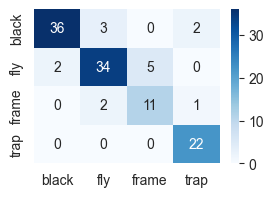

In [21]:
evaluation(grid_search_svm, X_test, y_test, labels)

# Árboles decisión

In [22]:
# Creamos un pipeline con la conversión a escala de grises, aplanado, normalización y clasificación dt
pipe_train_dt = Pipeline([
    ('gray', FunctionTransformer(convert_to_gray)),
    ('flatten', FunctionTransformer(lambda X_train: X_train.reshape((len(X_train), -1)))),
    ('normalize', StandardScaler()),
    ('DecTree', DecisionTreeClassifier())
])

param_grid = {
    'DecTree__criterion': ['gini', 'entropy','log_loss'],
    'DecTree__max_depth': [3, 5, 7],
    'DecTree__min_samples_split': [2, 5, 10],
    'DecTree__min_samples_leaf': [1, 2, 3],
    'DecTree__max_features': ['sqrt', 'log2']
}

# Creamos un objeto GridSearchCV con el pipeline y la cuadrícula de parámetros
grid_search_dt = GridSearchCV(pipe_train_dt, param_grid, cv=5, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('gray',
                                        FunctionTransformer(func=<function convert_to_gray at 0x0000018E32E1BE20>)),
                                       ('flatten',
                                        FunctionTransformer(func=<function <lambda> at 0x0000018E32E18040>)),
                                       ('normalize', StandardScaler()),
                                       ('DecTree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'DecTree__criterion': ['gini', 'entropy', 'log_loss'],
                         'DecTree__max_depth': [3, 5, 7],
                         'DecTree__max_features': ['sqrt', 'log2'],
                         'DecTree__min_samples_leaf': [1, 2, 3],
                         'DecTree__min_samples_split': [2, 5, 10]})

In [23]:
print('· GridSearch CV best score: {:.4f}'.format(grid_search_dt.best_score_))
print('· Parameters that give the best results:', (grid_search_dt.best_params_))
print('· Estimator that was chosen by the search:', (grid_search_dt.best_estimator_))

· GridSearch CV best score: 0.7096
· Parameters that give the best results: {'DecTree__criterion': 'gini', 'DecTree__max_depth': 7, 'DecTree__max_features': 'sqrt', 'DecTree__min_samples_leaf': 1, 'DecTree__min_samples_split': 10}
· Estimator that was chosen by the search: Pipeline(steps=[('gray',
                 FunctionTransformer(func=<function convert_to_gray at 0x0000018E32E1BE20>)),
                ('flatten',
                 FunctionTransformer(func=<function <lambda> at 0x0000018E32E18040>)),
                ('normalize', StandardScaler()),
                ('DecTree',
                 DecisionTreeClassifier(max_depth=7, max_features='sqrt',
                                        min_samples_split=10))])


# Evaluación del modelo clasificador DT

· GridSearch CV score: 0.7373
· Accuracy score: 0.7373
· Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65        41
           1       0.91      0.73      0.81        41
           2       0.92      0.79      0.85        14
           3       0.57      0.95      0.71        22

    accuracy                           0.74       118
   macro avg       0.77      0.77      0.75       118
weighted avg       0.77      0.74      0.74       118

· Confussion Matrix:


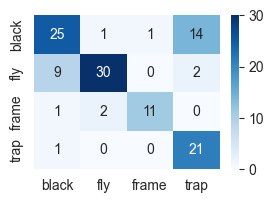

In [24]:
evaluation(grid_search_dt, X_test, y_test, labels)